# Hidden Markov Model
### Lehner White

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import itertools
import string
import codecs
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as mv

## Homework 1:

In [2]:
def calc_probs(A, B, pi):
    """
    A function to calculate the probabilities of all sets of observations
    
    Params:
    A: State transition matrix
    B: Observation Matrix
    pi: Initial state distribution
    
    Returns:
    Dict of probabilities for each set of observations
    """
    all_probs = []
    
    #iterate through all sets of observations
    for O1, O2, O3, O4 in itertools.product(np.arange(3), np.arange(3),np.arange(3),np.arange(3)):
        obs = [O1, O2, O3, O4]
        prob = 0
        
        #iterate through all states
        states = list(itertools.product(np.arange(2), np.arange(2), np.arange(2), np.arange(2)))
        
        for state in states:
            #calculate for state and observation combo
            ind_prob = pi[state[0]]
            ind_prob *= B[state[0], obs[0]]
            
            for i in xrange(1,len(state)):
                ind_prob *= A[state[i-1], state[i]]
                ind_prob *= B[ state[i], obs[i]]
            
            #add to actually probability
            prob += ind_prob
        
        #append to list of probabilities
        all_probs.append(prob)
        
    return all_probs

In [3]:
A = np.array([[0.7, 0.3], [0.4, 0.6]])
B = np.array([[0.1, 0.4, 0.5],[0.7, 0.2, 0.1]])
pi = np.array([0.6, 0.4])

print sum(calc_probs(A, B, pi))

1.0


In [4]:
def forward_probs(A, B, pi):
    """
    A function to calculate the probabilities of all sets of observations
    
    Params:
    A: State transition matrix
    B: Observation Matrix
    pi: Initial state distribution
    
    Returns:
    Dict of probabilities for each set of observations
    """
    
    all_probs = []
    
    #iterate through all sets of observations
    for O1, O2, O3, O4 in itertools.product(np.arange(3), np.arange(3),np.arange(3),np.arange(3)):
        obs = [O1, O2, O3, O4]
        n,m = B.shape
        T = len(obs)
        
        #use forward algorithm to comput probabilities
        alpha = np.zeros((T,n))
        alpha[0] = pi * B.T[O1]
        
        for i in xrange(1,T):
            for j in xrange(n):
                alpha[i,j] = np.sum(alpha[i-1] * A[:,j]) 
            alpha[i] *= B.T[obs[i]]
        all_probs.append(np.sum(alpha[-1]))
    
    return all_probs

In [5]:
print sum(forward_probs(A, B, pi))

1.0


# Lab 20:

In [6]:
class HMM:
    """
    An implementation of a Hidden Markov Model with methods for initializing 
    parameters and methods implementing various algorithms. 
    """
    def __init__(self, A, B, pi):
        """
        Initializes our attributes used in the algorithms
        
        Parameters:
        -----------
        A: State transition probability matrix
        B: Observation probability matrix
        pi: Initial state distribution
        """
        
        self.A = A
        self.B = B
        self.pi = pi
        self.obs = obs
        
        self.N = A.shape[0]
        self.M = B.shape[0]
        self.T = len(obs)
        
        return
    
    def _forward(self):
        """
        Compute the scaled forward probability matrix and scaling factors.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence

        Returns
        -------
        alpha : ndarray of shape (T,N)
            The scaled forward probability matrix
        c : ndarray of shape (T,)
            The scaling factors c = [c_1,c_2,...,c_T]
        """
        self.c = np.zeros(self.T)
        self.c[0] = 1 / np.dot(self.pi, self.B[self.obs[0], :])

        self.alpha = np.zeros( (self.T, self.N) )
        self.alpha[0] = self.c[0] * self.pi * self.B[self.obs[0], :]
        
        for t in xrange(1, self.T):
            self.c[t] = 1 / np.dot(self.A.dot(self.alpha[t-1,:]), self.B[self.obs[t], :])
            self.alpha[t,:] = self.c[t] * np.dot(self.A, self.alpha[t-1,:]) * self.B[self.obs[t], :]
        
        return
    
    def _backward(self):
        """
        Compute the scaled backward probability matrix.

        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence
        c : ndarray of shape (T,)
            The scaling factors from the forward pass

        Returns
        -------
        beta : ndarray of shape (T,N)
            The scaled backward probability matrix
        """
        self.beta = np.zeros( (self.T, self.N) )
        self.beta[self.T-1, :] = self.c[self.T-1]

        for t in xrange(self.T-2, -1, -1):
            self.beta[t,:] = self.c[t] * self.A.T.dot(self.B[self.obs[t+1], :] * self.beta[t+1, :])
                
        return
    
    def _delta(self):
        """
        Compute the delta probabilities.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence
        alpha : ndarray of shape (T,N)
            The scaled forward probability matrix from the forward pass
        beta : ndarray of shape (T,N)
            The scaled backward probability matrix from the backward pass
        
        Returns
        -------
        delta : ndarray of shape (T-1,N,N)
            The delta probability array
        gamma : ndarray of shape (T,N)
            The gamma probability array
        """
        
        self.delta = np.zeros((self.T-1, self.N, self.N))
        self.gamma = np.zeros((self.T, self.N))
        
        for t in xrange(self.T-1):
            for i in xrange(self.N):
                for j in xrange(self.N):
                    self.delta[t,i,j] = self.alpha[t,i] * self.A[j,i] * self.B[self.obs[t+1], j] * self.beta[t+1,j]
        
        self.gamma[:-1] = np.sum(self.delta, axis = 2)
        self.gamma[-1] = self.alpha[-1] * self.beta[-1] / np.dot(self.alpha[-1], self.beta[-1])
        
        return
    
    def _estimate(self):
        """
        Estimate better parameter values.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence
        delta : ndarray of shape (T-1,N,N)
            The delta probability array
        gamma : ndarray of shape (T,N)
            The gamma probability array
        """
        # update self.A, self.B, self.pi in place

        for i in xrange(self.N):
            for j in xrange(self.N):
                denom = np.sum(self.gamma[:-1,j], axis = 0)
                self.A[i, j] = np.sum(self.delta[:,j,i], axis = 0)
                self.A[i, j] /= denom
                    
        for i in xrange(self.M):
            ind = (self.obs == i)
            for j in xrange(self.N):
                denom = np.sum(self.gamma[:,j], axis = 0)
                self.B[i, j] = np.sum(self.gamma[:,j] * ind, axis = 0)
                self.B[i, j] /= denom
        
        self.pi = self.gamma[0,:]
        
        return
    
    def fit(self, obs, A, B, pi, max_iter=100, tol=1e-3):
        """
        Fit the model parameters to a given observation sequence.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
            Observation sequence on which to train the model.
        A : stochastic ndarray of shape (N,N)
            Initialization of state transition matrix
        B : stochastic ndarray of shape (M,N)
            Initialization of state observation matrix
        pi : stochastic ndarray of shape (N,)
            Initialization of initial state distribution
        max_iter : integer
            The maximum number of iterations to take
        tol : float
            The convergence threshold for change in log-probability
        """
        # initialize self.A, self.B, self.pi               
        self.A = A
        self.B = B
        self.pi = pi
        self.obs = obs
        
        self.N = A.shape[0]
        self.M = B.shape[0]
        self.T = len(obs)
        
        # run the iteration
        iters = 0
        distance = 100.
        h._forward()
        log_probs = [- np.sum(np.log(self.c))]
        while distance > tol and iters < max_iter:
            h._forward()
            h._backward()
            h._delta()
            h._estimate()
            h._forward()
            log_probs.append( - np.sum(np.log(self.c)))
            distance = np.abs(log_probs[-2] - log_probs[-1])
            iters += 1
        self.log_probs = log_probs
        plt.plot(self.log_probs)
        plt.xlabel('Iterations')
        plt.ylabel('Log Prob')
        plt.show()
        return
        

## Problem 2:

In [7]:
# toy HMM example to be used to check answers
A = np.array([[.7, .4],[.3, .6]])
B = np.array([[.1,.7],[.4, .2],[.5, .1]])
pi = np.array([.6, .4])
obs = np.array([0, 1, 0, 2])

In [8]:
h = HMM(A, B, pi)
h._forward()
print -(np.log(h.c)).sum() # the log prob of observation

-4.6429135909


## Problem 3:

In [9]:
h._backward()
print h.beta

[[ 3.1361635   2.89939354]
 [ 2.86699344  4.39229044]
 [ 3.898812    2.66760821]
 [ 3.56816483  3.56816483]]


## Problem 4:

In [10]:
h._delta()
print h.delta
print h.gamma

[[[ 0.14166321  0.0465066 ]
  [ 0.37776855  0.43406164]]

 [[ 0.17015868  0.34927307]
  [ 0.05871895  0.4218493 ]]

 [[ 0.21080834  0.01806929]
  [ 0.59317106  0.17795132]]]
[[ 0.18816981  0.81183019]
 [ 0.51943175  0.48056825]
 [ 0.22887763  0.77112237]
 [ 0.8039794   0.1960206 ]]


## Problem 5:

In [11]:
h._estimate()
print h.A
print h.B
print h.pi

[[ 0.55807991  0.49898142]
 [ 0.44192009  0.50101858]]
[[ 0.23961928  0.70056364]
 [ 0.29844534  0.21268397]
 [ 0.46193538  0.08675238]]
[ 0.18816981  0.81183019]


## Problems 7 and 8:

In [12]:
def vec_translate(a, my_dict):
    # translate numpy array from symbols to state numbers or vice versa
    return np.vectorize(my_dict.__getitem__)(a)

def prep_data(filename):
    # Get the data as a single string
    with codecs.open(filename, encoding='utf-8') as f:
        data=f.read().lower() #and convert to all lower case
    
    # remove punctuation and newlines
    remove_punct_map = {ord(char): None for char in string.punctuation+"\n\r"}
    data = data.translate(remove_punct_map)
    
    # make a list of the symbols in the data
    symbols = sorted(list(set(data)))
    
    # convert the data to a NumPy array of symbols
    a = np.array(list(data))
    
    #make a conversion dictionary from symbols to state numbers
    symbols_to_obsstates = {x:i for i,x in enumerate(symbols)}
    
    #convert the symbols in a to state numbers
    obs_sequence = vec_translate(a,symbols_to_obsstates)
    
    return symbols, obs_sequence

In [13]:
symbols, obs = prep_data('declaration.txt')

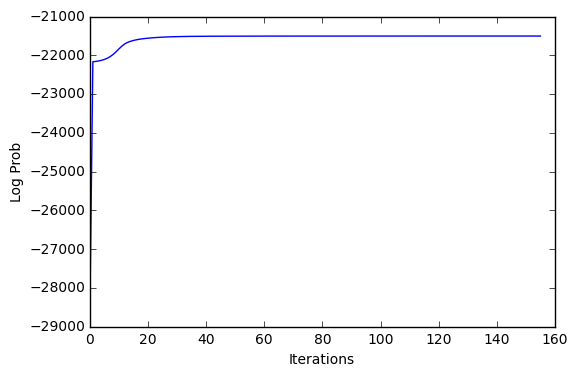

 , 0.0487, 0.3000
a, 0.0000, 0.1316
b, 0.0226, 0.0000
c, 0.0438, 0.0000
d, 0.0600, 0.0000
e, 0.0000, 0.2370
f, 0.0428, 0.0000
g, 0.0309, 0.0000
h, 0.0826, 0.0005
i, 0.0000, 0.1239
j, 0.0038, 0.0000
k, 0.0030, 0.0004
l, 0.0543, 0.0000
m, 0.0343, 0.0000
n, 0.1150, 0.0000
o, 0.0035, 0.1375
p, 0.0329, 0.0000
q, 0.0014, 0.0000
r, 0.1012, 0.0000
s, 0.1138, 0.0000
t, 0.1523, 0.0000
u, 0.0000, 0.0577
v, 0.0176, 0.0000
w, 0.0231, 0.0000
x, 0.0021, 0.0000
y, 0.0094, 0.0115
z, 0.0010, 0.0000


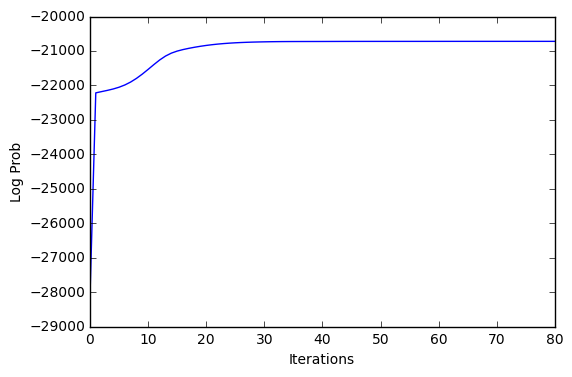

 , 0.2094, 0.2720
a, 0.0000, 0.1738
b, 0.0017, 0.0000
c, 0.0165, 0.0000
d, 0.0694, 0.0000
e, 0.1501, 0.1808
f, 0.0101, 0.0000
g, 0.0329, 0.0000
h, 0.1445, 0.0000
i, 0.0234, 0.1430
j, 0.0048, 0.0000
k, 0.0028, 0.0010
l, 0.0423, 0.0000
m, 0.0142, 0.0011
n, 0.0000, 0.0000
o, 0.0414, 0.1505
p, 0.0139, 0.0000
q, 0.0016, 0.0000
r, 0.0393, 0.0000
s, 0.0633, 0.0017
t, 0.0824, 0.0000
u, 0.0000, 0.0762
v, 0.0045, 0.0000
w, 0.0018, 0.0000
x, 0.0000, 0.0000
y, 0.0296, 0.0000
z, 0.0000, 0.0000


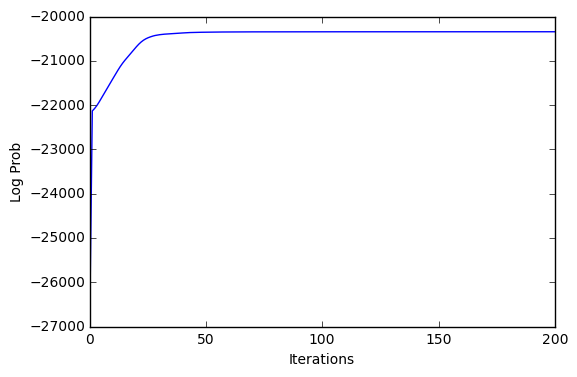

 , 0.0143, 0.0000
a, 0.0000, 0.1921
b, 0.0363, 0.0000
c, 0.0643, 0.0000
d, 0.0287, 0.0000
e, 0.0000, 0.3491
f, 0.0547, 0.0000
g, 0.0054, 0.0000
h, 0.2542, 0.0000
i, 0.0516, 0.1592
j, 0.0144, 0.0000
k, 0.0027, 0.0001
l, 0.0870, 0.0000
m, 0.0404, 0.0000
n, 0.0222, 0.0000
o, 0.0246, 0.1973
p, 0.0465, 0.0000
q, 0.0000, 0.0000
r, 0.1153, 0.0000
s, 0.0241, 0.0000
t, 0.0588, 0.0018
u, 0.0087, 0.0795
v, 0.0072, 0.0000
w, 0.0387, 0.0000
x, 0.0000, 0.0000
y, 0.0000, 0.0209
z, 0.0000, 0.0000


In [14]:
for N in xrange(2,5):
    M = len(symbols)
    A = np.random.dirichlet(np.ones(N), size=N).T
    B = np.random.dirichlet(np.ones(M), size=N).T
    pi = np.random.dirichlet(np.ones(N))

    h.fit(obs, A, B, pi, max_iter=200)

    for i in xrange(len(h.B)):
        print "{0}, {1:0.4f}, {2:0.4f}".format(symbols[i], h.B[i,0], h.B[i,1])

Its obvious to see that the model is doing a fairly good job at identifying the two states as vowels and consonants. With more states the letters were broken up into groups that Im not really sure what they mean.

## Problem 9:

In [15]:
symbols, obs = prep_data('WarAndPeace.txt')

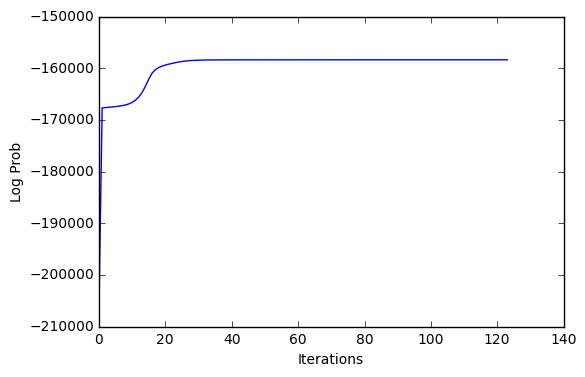

 , 0.2146, 0.0878
́, 0.0001, 0.0000
а, 0.0000, 0.1759
б, 0.0250, 0.0000
в, 0.0655, 0.0000
г, 0.0296, 0.0000
д, 0.0385, 0.0001
е, 0.0180, 0.1427
ж, 0.0140, 0.0000
з, 0.0252, 0.0000
и, 0.0016, 0.1315
й, 0.0149, 0.0000
к, 0.0497, 0.0011
л, 0.0719, 0.0000
м, 0.0381, 0.0000
н, 0.0973, 0.0000
о, 0.0000, 0.2407
п, 0.0346, 0.0062
р, 0.0597, 0.0000
с, 0.0513, 0.0280
т, 0.0780, 0.0000
у, 0.0000, 0.0590
ф, 0.0018, 0.0003
х, 0.0111, 0.0000
ц, 0.0049, 0.0000
ч, 0.0167, 0.0038
ш, 0.0109, 0.0000
щ, 0.0047, 0.0000
ъ, 0.0003, 0.0003
ы, 0.0000, 0.0376
ь, 0.0009, 0.0433
э, 0.0000, 0.0066
ю, 0.0079, 0.0024
я, 0.0128, 0.0328
ё, 0.0000, 0.0001


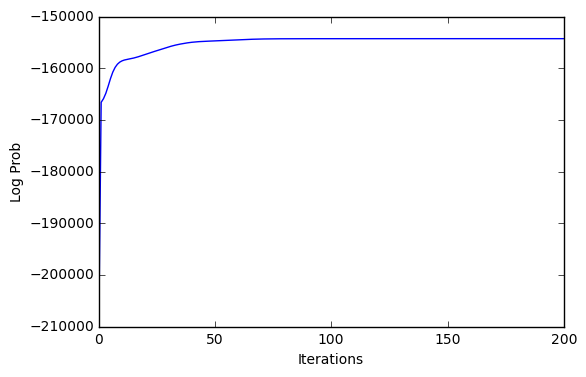

 , 0.8797, 0.0004
́, 0.0002, 0.0001
а, 0.0000, 0.0000
б, 0.0016, 0.0321
в, 0.0000, 0.0858
г, 0.0000, 0.0387
д, 0.0202, 0.0423
е, 0.0257, 0.0076
ж, 0.0007, 0.0180
з, 0.0086, 0.0296
и, 0.0000, 0.0000
й, 0.0000, 0.0196
к, 0.0000, 0.0660
л, 0.0000, 0.0941
м, 0.0000, 0.0499
н, 0.0000, 0.1274
о, 0.0000, 0.0000
п, 0.0000, 0.0507
р, 0.0000, 0.0782
с, 0.0551, 0.0692
т, 0.0000, 0.1020
у, 0.0000, 0.0000
ф, 0.0000, 0.0026
х, 0.0000, 0.0145
ц, 0.0000, 0.0065
ч, 0.0000, 0.0252
ш, 0.0032, 0.0130
щ, 0.0000, 0.0062
ъ, 0.0000, 0.0006
ы, 0.0000, 0.0000
ь, 0.0000, 0.0000
э, 0.0000, 0.0000
ю, 0.0006, 0.0088
я, 0.0045, 0.0108
ё, 0.0000, 0.0000


In [16]:
for N in xrange(2,4):
    M = len(symbols)
    A = np.random.dirichlet(np.ones(N), size=N).T
    B = np.random.dirichlet(np.ones(M), size=N).T
    pi = np.random.dirichlet(np.ones(N))

    h.fit(obs, A, B, pi, max_iter=200)

    for i in xrange(len(h.B)):
        print u"{0}, {1:0.4f}, {2:0.4f}".format(symbols[i], h.B[i,0], h.B[i,1])

Again our model does what I assume is an efficient job of seperating the vowels and consonants out of the text, but Im not sure what the differences are in the group of 3 states.

# Gaussian HMM

## Problem 1:

In [62]:
def gen_obs(T, pi, A, mu=None, sigma=None):
    obs = np.zeros((T, mu.shape[1]))
    states = np.zeros(T)
    for t in xrange(T):
        if t == 0:
            states[t] = np.argmax( np.random.multinomial(1,pi) )
        else:
            states[t] = np.argmax( np.random.multinomial(1,A[states[t-1],:]) )
        obs[t] = np.random.multivariate_normal(mu[states[t]], sigma[states[t]])
    return obs

In [63]:
T = 5000
pi = np.array([0.3, 0.7])
A = np.array([[0.4, 0.6], [0.9, 0.1]])
mu = np.array([[2, 0], [0,2]])
sigma = np.array([[[1, 0], [0, 1]], [[0.5, 0],[0, 1]]])

In [64]:
obs = gen_obs(T, pi, A, mu, sigma)
print obs

/Users/Lehner/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Lehner/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[ 0.85086956  1.72036521]
 [ 3.84793056  0.8886199 ]
 [-0.81257613  2.47273066]
 ..., 
 [ 3.67311671 -1.82472638]
 [-1.0271212   2.76729823]
 [ 1.55626193  1.15660999]]


## Problem 2:

In [65]:
class GHMM:
    """
    An implementation of a Hidden Markov Model with methods for initializing 
    parameters and methods implementing various algorithms. 
    """
    def __init__(self, A, mu, sigma, pi, obs):
        """
        Initializes our attributes used in the algorithms
        
        Parameters:
        -----------
        A: State transition probability matrix
        B: Observation probability matrix
        pi: Initial state distribution
        """
        
        self.A = A
        self.mu = mu
        self.sigma = sigma
        self.pi = pi
        self.obs = obs
        
        self.N = A.shape[0]
        self.T = len(obs)
        
        return
    
    def _forward(self):
        """
        Compute the scaled forward probability matrix and scaling factors.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence

        Returns
        -------
        alpha : ndarray of shape (T,N)
            The scaled forward probability matrix
        c : ndarray of shape (T,)
            The scaling factors c = [c_1,c_2,...,c_T]
        """
        B = np.array([mv.pdf(self.obs[0], mean=self.mu[i], cov=self.sigma[i]) for i in xrange(self.N)])
        
        self.alpha = np.zeros( (self.T, self.N) )
        self.alpha[0] = self.pi * B
        
        self.c = np.zeros(self.T)
        self.c[0] = 1 / np.sum(self.alpha[0, :])

        self.alpha[0] *= self.c[0]
        
        for t in xrange(1, self.T):
            B = np.array([mv.pdf(self.obs[t], mean=self.mu[i], cov=self.sigma[i]) for i in xrange(self.N)])
            self.c[t] = 1 / np.sum(self.alpha[t-1,:])
            self.alpha[t,:] = self.c[t] * np.dot(self.alpha[t-1,:], self.A) * B
        
        return
    
    def _backward(self):
        """
        Compute the scaled backward probability matrix.

        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence
        c : ndarray of shape (T,)
            The scaling factors from the forward pass

        Returns
        -------
        beta : ndarray of shape (T,N)
            The scaled backward probability matrix
        """
        self.beta = np.zeros( (self.T, self.N) )
        self.beta[self.T-1, :] = self.c[self.T-1]

        for t in xrange(self.T-2, -1, -1):
            B = np.array([mv.pdf(self.obs[t+1], mean=self.mu[i], cov=self.sigma[i]) for i in xrange(self.N)])
            self.beta[t,:] = self.c[t] * np.sum(self.A * B * self.beta[t+1, :], axis=1)
                
        return
    
    def _delta(self):
        """
        Compute the delta probabilities.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence
        alpha : ndarray of shape (T,N)
            The scaled forward probability matrix from the forward pass
        beta : ndarray of shape (T,N)
            The scaled backward probability matrix from the backward pass
        
        Returns
        -------
        delta : ndarray of shape (T-1,N,N)
            The delta probability array
        gamma : ndarray of shape (T,N)
            The gamma probability array
        """
        
        self.delta = np.zeros((self.T-1, self.N, self.N))
        self.gamma = np.zeros((self.T, self.N))
        
        for t in xrange(self.T-1):
            for i in xrange(self.N):
                for j in xrange(self.N):
                    B = mv.pdf(self.obs[t+1], mean=self.mu[j], cov=self.sigma[j])
                    self.delta[t,i,j] = self.alpha[t,i] * self.A[j,i] * B * self.beta[t+1,j]
        
        self.gamma[:-1] = np.sum(self.delta, axis = 2)
        self.gamma[-1] = self.alpha[-1] * self.beta[-1] / np.dot(self.alpha[-1], self.beta[-1])
        
        return
    
    def _estimate(self):
        """
        Estimate better parameter values.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence
        delta : ndarray of shape (T-1,N,N)
            The delta probability array
        gamma : ndarray of shape (T,N)
            The gamma probability array
        """
        # update self.A, self.B, self.pi in place

        for i in xrange(self.N):
            for j in xrange(self.N):
                denom = np.sum(self.gamma[:-1,j], axis = 0)
                self.A[i, j] = np.sum(self.delta[:,j,i], axis = 0)
                self.A[i, j] /= denom
                    
        for i in xrange(self.N):
            denom = np.sum(self.gamma[t,i] for t in xrange(T))
            self.mu[i] = np.sum([self.gamma[t, i] * self.obs[t] for t in xrange(self.T)])
            self.mu[i] /= denom
            
            self.sigma[i] = np.diag(np.sum([self.gamma[t,i]*(self.obs[t]-self.mu[i])**2 for t in range(self.T)], axis =0))            
            self.sigma[i] /= denom

            
        self.pi = self.gamma[0,:]
        
        return
    
    def fit(self, obs, A, mu, sigma, pi, max_iter=100, tol=1e-3):
        """
        Fit the model parameters to a given observation sequence.
        
        Parameters
        ----------
        obs : ndarray of shape (T,)
            Observation sequence on which to train the model.
        A : stochastic ndarray of shape (N,N)
            Initialization of state transition matrix
        B : stochastic ndarray of shape (M,N)
            Initialization of state observation matrix
        pi : stochastic ndarray of shape (N,)
            Initialization of initial state distribution
        max_iter : integer
            The maximum number of iterations to take
        tol : float
            The convergence threshold for change in log-probability
        """
        # initialize self.A, self.B, self.pi               
        self.A = A
        self.mu = mu
        self.sigma = sigma
        self.pi = pi
        self.obs = obs
        
        self.N = A.shape[0]
        self.T = len(obs)
        
        # run the iteration
        iters = 0
        distance = 100.
        h._forward()
        log_probs = [- np.sum(np.log(self.c))]
        while distance > tol and iters < max_iter:
            h._forward()
            h._backward()
            h._delta()
            h._estimate()
            h._forward()
            log_probs.append( - np.sum(np.log(self.c)))
            distance = np.abs(log_probs[-2] - log_probs[-1])
            iters += 1
        self.log_probs = log_probs
        plt.plot(self.log_probs)
        plt.xlabel('Iterations')
        plt.ylabel('Log Prob')
        plt.show()
        return
        

/Users/Lehner/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:145: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


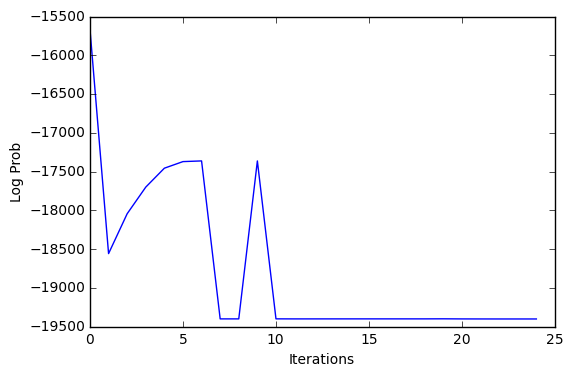

In [66]:
h = GHMM(A, mu, sigma, pi, obs)
h.fit(obs, A, mu, sigma, pi)

In [68]:
print h.mu
print h.sigma

[[2 2]
 [2 2]]
[[[ 2.3412345   0.        ]
  [ 0.          3.41755307]]

 [[ 1.32079686  0.        ]
  [ 0.          0.07819606]]]


As we can see it did alright. It detected the means of 2, but had a hard time with the zeros. It had a much harder time getting the sigma matrices correct. 